#### 1. Library import and GPU check:

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.9.1
Eager mode:  True
Hub version:  0.12.0
GPU is available


#### 2. Next we load the *IMDB* dataset:

In [2]:
train_data, test_data = tfds.load(name='imdb_reviews', split=['train', 'test'], batch_size=-1, as_supervised=True)

train_examples, train_labels = tfds.as_numpy(train_data)
test_examples, test_labels = tfds.as_numpy(test_data)

In [3]:
print('Training entries: {}, test entries: {}'.format(len(train_examples), len(test_examples)))

Training entries: 25000, test entries: 25000


In [4]:
r = 0
train_examples[r], train_labels[r]

(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
 0)

#### 3. Let's try some pre-trained word embedding models:

In [5]:
model = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(model, input_shape=[], dtype=tf.string, trainable=True)
hub_layer(train_examples[:1]) # feature vector of a sngle review

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.5423195 , -0.0119017 ,  0.06337538,  0.06862972, -0.16776837,
        -0.10581174,  0.16865303, -0.04998824, -0.31148055,  0.07910346,
         0.15442263,  0.01488662,  0.03930153,  0.19772711, -0.12215476,
        -0.04120981, -0.2704109 , -0.21922152,  0.26517662, -0.80739075,
         0.25833532, -0.3100421 ,  0.28683215,  0.1943387 , -0.29036492,
         0.03862849, -0.7844411 , -0.0479324 ,  0.4110299 , -0.36388892,
        -0.58034706,  0.30269456,  0.3630897 , -0.15227164, -0.44391504,
         0.19462997,  0.19528408,  0.05666234,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201318 , -0.04418665, -0.08550783,
        -0.55847436, -0.23336391, -0.20782952, -0.03543064, -0.17533456]],
      dtype=float32)>

#### 4. Build the model:

In [6]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


#### 4. Add a loss function:

Cross entropy can be a good fit for classification as it compares probability distributions.

In [7]:
model.compile(optimizer='adam',
             loss=tf.losses.BinaryCrossentropy(from_logits=True),
             metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

#### 5. We need to split out a validation set from the training set:

In [8]:
x_val = train_examples[:10000]
partial_x_train = train_examples[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

#### 6. Train the model:

40 epochs of mini-batches (512 samples each). Validation set is used to calculate accuracy (as cross entropy is used as the error function?).

In [9]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=40,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/40
30/30 [==============================] - 3s 58ms/step - loss: 0.6535 - accuracy: 0.6391 - val_loss: 0.6056 - val_accuracy: 0.7326
Epoch 2/40
30/30 [==============================] - 2s 51ms/step - loss: 0.5393 - accuracy: 0.7965 - val_loss: 0.4941 - val_accuracy: 0.8050
Epoch 3/40
30/30 [==============================] - 2s 51ms/step - loss: 0.4037 - accuracy: 0.8581 - val_loss: 0.3949 - val_accuracy: 0.8427
Epoch 4/40
30/30 [==============================] - 2s 51ms/step - loss: 0.2891 - accuracy: 0.9015 - val_loss: 0.3401 - val_accuracy: 0.8602
Epoch 5/40
30/30 [==============================] - 2s 52ms/step - loss: 0.2102 - accuracy: 0.9319 - val_loss: 0.3133 - val_accuracy: 0.8705
Epoch 6/40
30/30 [==============================] - 2s 52ms/step - loss: 0.1546 - accuracy: 0.9573 - val_loss: 0.3027 - val_accuracy: 0.8735
Epoch 7/40
30/30 [==============================] - 2s 51ms/step - loss: 0.1122 - accuracy: 0.9737 - val_loss: 0.3017 - val_accuracy: 0.8758
Epoch 8/40
30

#### 7. Evaluate the model:

In [10]:
results = model.evaluate(test_examples, test_labels)

print(results)

782/782 [==============================] - 4s 5ms/step - loss: 0.6335 - accuracy: 0.8454
[0.6335000395774841, 0.8454399704933167]


#### 8. Accuracy over time:

We are going to use a *History* object of the dictionary type returned by *model.fit()*.

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Plotting values for the above dictionary keys:

In [12]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

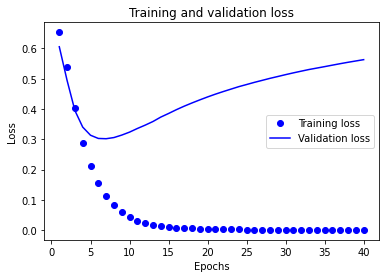

In [15]:
# 'bo' is for 'blue dot'
plt.plot(epochs, loss, 'bo', label='Training loss')
# 'b' is for 'solid blue line'
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

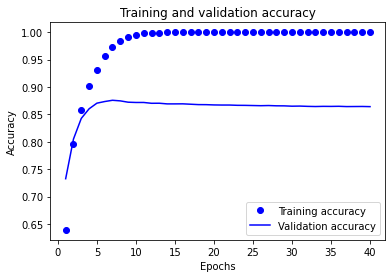

In [17]:
plt.clf() # clear figure

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The above graphs indicate overfitting.